<a href="https://colab.research.google.com/github/giaminhkieu/AuNC_TDA/blob/main/PI_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Persistence Images and Simplical complex features to predict AuNC properties

1. This notebook focuses on generating persistence images and simplicial complex count and using them to build a Kernel Ridge Regression and Random Forest Regression model to predict the HOMO-LUMO gap, internal energies, and dipole moment of AuNCs.
2. Persistence Images were generated using the code in Townsend *et. al.* 2020 publication, publicly available at: https://gitlab.com/voglab/PersistentImages_Chemistry


# Installations

In [ ]:
!pip install gudhi
!pip install ripser
!pip install elements
!pip install qml
!pip install dscribe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ripser: filename=ripser-0.6.4-cp310-cp310-linux_x86_64.whl size=752978 sha256=c316e2cfaad2d0074a37a702b974119b905c4de95176f8fb7dc9cb2c37ea5620
  Stored in directory: /root/.cache/pip/wheels/c5/f5/66/f41f708b049057431155934f74e20ca6001a085fcd2e615150
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18103 sha256=a7cec3079b30d592b12cf002653e0b49cccab92db8d54b13fd72310d52630f17
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built ripser hopcroftkarp
  P

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/URECA_22')
import pandas as pd
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import qml
from qml.representations import *
from natsort import natsorted
from dscribe.descriptors import SOAP
from ase.io import read

import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import time


# Process data and store them to pickle files



In [ ]:
# import dataframe
os.chdir('/content/drive/MyDrive/AuNC database')
DatasetAuNC = pd.read_excel("DatasetAuNC_XTB_290723.xlsx")


,Clusters,Filename,Charge,Ligands1,Type1,Quantity1,Ligands2,Type2,Quantity2,Ligands3,Type3,Quantity3,u298,gap,dipX,dipY,dipZ,mu,core
0,Au(PPh3)(CH3),Au_PPh3_CH3_c0,0,PPh3,PPh3,1,CH3,others,1,0,others,0,-56.400818,1.946276,-0.4391,2.4436,-1.3932,7.236,1
1,Au(SbPh3)4,Au_SbPh3_4_c0,0,SbPh3,PPh3,4,0,others,0,0,others,0,-198.398732,2.058591,0.5488,0.0287,0.1793,1.469,1
2,Au(SbPh3)Cl,Au_SbPh3_Cl_c0,0,SbPh3,PPh3,1,Cl,Halogens,1,0,others,0,-56.829549,3.519847,0.3156,3.6059,-1.8031,10.279,1
3,Au(SbTol3)3(SbCl2Tol2),Au_SbTol3_3_SbCl2Tol2_c0,0,SbTol3,PPh3,3,SbCl2Tol2,PPh3,1,0,others,0,-226.946163,3.277166,-0.6295,-2.4385,1.0070,6.894,1
4,[Au2(PET)(PPh3)2]+,Au2_PET_PPh3_2_c1,1,PET,SX,1,PPh3,PPh3,2,0,others,0,-130.543475,3.157827,2.3911,0.2794,32.0597,81.717,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,Au103S2(S-Nap)41,Au103_S2_SNap_41_c0,0,S,S,2,S-Nap,SX,41,0,others,0,-1594.470972,0.324921,-0.1763,-1.6961,-0.2783,4.392,103
208,Au108S24(PPh3)16,Au108_S24_PPh3_16_c0,0,PPh3,PPh3,16,S,S,24,0,others,0,-1302.446940,0.485519,0.0193,-0.0230,-0.0275,0.103,108
209,[Au110(p-CF3C6H4CC)48]2-,Au110_CCPhCF3_48_c-2,-2,p-CF3C6H4CC,CCR,48,0,others,0,0,others,0,-2195.283841,0.153487,-57.1284,-66.4725,-44.5142,249.865,110
210,Au133(TBBT)52,Au133_TBBT_52_c0,0,TBBT,SX,52,0,others,0,0,others,0,-2192.276830,0.068608,0.0956,-1.9440,-0.0162,4.947,133


In [ ]:
# Appending xyz

os.chdir('/content/drive/MyDrive/AuNC database/Optimized_geometries')

xyz_list = []
files = []
for i in tqdm(range(len(DatasetAuNC))):
    try:
        xyz_filename = DatasetAuNC["Filename"][i] + ".xyz"
        with open(xyz_filename) as f:
            lines = f.readlines()
            files.append(xyz_filename)
            xyz_list.append(lines)
    except FileNotFoundError as e:
        print(f"Error: File '{xyz_filename}' not found.")
    except Exception as e:
        print(f"Error at index {i}: {str(e)}")
        continue

DatasetAuNC["xyz"] = xyz_list

100%|██████████| 212/212 [00:00<00:00, 376.41it/s]


In [ ]:
# Calculating Betti feature count for overview

Error = []
B0_list = []
B1_list = []
B2_list = []

for i in range(len(DatasetAuNC)):
  try:
    D, elements = Makexyzdistance(DatasetAuNC["xyz"][i])
    persistent_homology_features = ripser(D,distance_matrix=True, maxdim = 2)
    B0_list.append(len(persistent_homology_features['dgms'][0])-1)
    B1_list.append(len(persistent_homology_features['dgms'][1]))
    B2_list.append(len(persistent_homology_features['dgms'][2]))

  except:
    Error.append(DatasetAuNC["Number"][i])
    continue

DatasetAuNC["Betti0count"] = B0_list
DatasetAuNC["Betti1count"] = B1_list
DatasetAuNC["Betti2count"] = B2_list

print("Finished appending Betti feature count!")

In [ ]:
"""
Calculating and appending VariancePersist arrays to pandas dataframe
VariancePersistv1 is a modified PI function with added buffer values
(0.5, 0.05) for Betti 1 and 2 features.
Except block is added due to some xyz file having values written in different notations (e.g. 1e-4)
and cannot be read as a float. (current AuNC database does not have this issue)
"""


def append_persistence_image(Dataframe):
  Error = []
  PersImgArr = []

  for idx in range(len(Dataframe)):
    try:
        persistent_image_matrix = VariancePersistv1(
                              Dataframe["xyz"][idx],
                              pixelx=resolution,
                              pixely=resolution,
                              myspread=myspread ,
                              myspecs={"maxBD": max_bound, "minBD":min_bound},
                              electroneg_addition=electroneg_addition,
                              electroneg_division=electroneg_division,
                              B1_buffer=B1_buffer,
                              B2_buffer=B2_buffer,
                              showplot = False
                              )

        PersImgArr.append(persistent_image_matrix)
    except:
        Error.append(idx)
        print("Error at index: ", idx)
        PersImgArr.append(np.zeros(resolution*resolution,))

  Dataframe["PersImg"] = PersImgArr
  print("Finished appending Persistence Images!")

In [ ]:
#Persistence Image Parameters
resolution=100
myspread=0.3
min_bound=-0.3
max_bound=7
electroneg_addition=+0.4
electroneg_division=10
B1_buffer=0.5
B2_buffer=0.05

append_persistence_image(DatasetAuNC)

In [ ]:
# Simplcial complex analysis
def Simplex_analyze(Core_coordinates, bond_length_limit):
  rips= gudhi.RipsComplex(points=list(Core_coordinates), max_edge_length=10.0)
  simplex_tree = rips.create_simplex_tree(max_dimension=3)
  simplex_generator = simplex_tree.get_skeleton(3)

  Tetrahedra_list = []
  Vertices_of_tetrahedra = []
  Overlapping_triangles = []
  Unconnected_triangles = []
  Triangles_with_1_shared_vertex = []
  Triangles_with_2_shared_vertices = []

  for simplex in simplex_generator:
    if simplex[1] >= bond_length_limit: continue
    if len(simplex[0]) == 4: #simplex[0]: list of vertices, simplex[1]: birth filtration
      Tetrahedra_list.append(simplex)
      for vertex in simplex[0]:
        if vertex not in Vertices_of_tetrahedra:
          Vertices_of_tetrahedra.append(vertex)

  rips= gudhi.RipsComplex(points=list(Core_coordinates), max_edge_length=10.0)
  simplex_tree = rips.create_simplex_tree(max_dimension=3)
  simplex_generator = simplex_tree.get_skeleton(3)

  for simplex in simplex_generator:
    Shared_count_arr = []

    if simplex[1] >= bond_length_limit: continue
    if len(simplex[0]) != 3: continue

    if len(Tetrahedra_list) == 0: Unconnected_triangles.append(simplex[0])
    else:
      for tetrahedra in Tetrahedra_list:
        Shared_count_arr.append(len(set(simplex[0]) & set(tetrahedra[0])))

      if max(Shared_count_arr) == 3: Overlapping_triangles.append(simplex)
      elif max(Shared_count_arr) == 2: Triangles_with_2_shared_vertices.append(simplex)
      elif max(Shared_count_arr) == 1: Triangles_with_1_shared_vertex.append(simplex)
      else: Unconnected_triangles.append(simplex)

  return {"Tetrahedral_count": len(Tetrahedra_list), "Unconnected_triangles_count": len(Unconnected_triangles),
          "Triangles_with_1_shared_vertex_count":len(Triangles_with_1_shared_vertex),
          "Triangles_with_2_shared_vertices_count": len(Triangles_with_2_shared_vertices)}


In [ ]:
"""
Simplex analysis
"""

Tetrahedral_count_arr = []
Unconnected_triangles_count_arr = []
Triangles_with_1_shared_vertex_count_arr = []
Triangles_with_2_shared_vertices_count_arr = []
files = []

for idx in range(len(DatasetAuNC)):
  try:
    filename = DatasetAuNC["Filename"][idx] + ".xyz"
    df=pd.read_table(filename, delim_whitespace=True, names=['a','b','c','d'],skiprows = 2) # skip the first 2 lines of xyz files
    mat = df[['b','c','d']].to_numpy()
    ElementArr = df['a'].to_numpy()

    Core_coordinates = []

    for index in range(len(ElementArr)):
      if ElementArr[index] != "Au": continue
      Core_coordinates.append(mat[index])

    Dict = Simplex_analyze(Core_coordinates, bond_length_limit = 4.0)

    Tetrahedral_count_arr.append(Dict["Tetrahedral_count"])
    Unconnected_triangles_count_arr.append(Dict["Unconnected_triangles_count"])
    Triangles_with_1_shared_vertex_count_arr.append(Dict["Triangles_with_1_shared_vertex_count"])
    Triangles_with_2_shared_vertices_count_arr.append(Dict["Triangles_with_2_shared_vertices_count"])

    print("Done: ", i)
    print(len(Tetrahedral_count_arr))


  except:
    print("error at: ", i)
    continue

DatasetAuNC["Tetrahedral_count"] = Tetrahedral_count_arr
DatasetAuNC["Unconnected_triangles_count"] = Unconnected_triangles_count_arr
DatasetAuNC["Triangles_with_1_shared_vertex_count"] = Triangles_with_1_shared_vertex_count_arr
DatasetAuNC["Triangles_with_2_shared_vertices_count"] = Triangles_with_2_shared_vertices_count_arr

print("Finished appending Simplex count!")

In [ ]:
"""
Calculating and appending Coulomb Matrix arrays to pandas dataframe
"""
def append_cm(dataframe, xyz_root):
  CoulMatArr = []
  for f in natsorted(os.listdir(xyz_root)):
    try:
      mol = qml.Compound(xyz=f)
      mol.generate_coulomb_matrix(size=2000, sorting="row-norm")
      A = mol.representation
      CoulMatArr.append([f,A])
    except:
      print("Error at: ", f)

  # Sample array containing the format ["Filename.xyz", property array]
  property_arrays = np.empty(len(dataframe), dtype=object)

  for filename, property_array in CoulMatArr:
      filename_without_extension = filename.split('.xyz')[0]
      row_index = dataframe.index[dataframe['Filename'] == filename_without_extension]

      if len(row_index) == 1:
          property_arrays[row_index[0]] = property_array
      else:
          print(f"Filename '{filename_without_extension}' not found in the DataFrame.")

  dataframe['Coulomb_Matrix'] = property_arrays
  print("Finished appending Coulomb Matrices!")

append_cm(DatasetAuNC, "/content/drive/MyDrive/AuNC database/Optimized_geometries")

In [ ]:
"""
Calculating and appending SOAP arrays to pandas dataframe
"""
def append_soap(dataframe, xyz_root):
  species = ["Au", "P", "S", "Sb", "Se", "Cl", "Br", "F", "C", "N", "O", "H", "I", "Fe"]
  r_cut = 6.0
  n_max = 8
  l_max = 6

  soap = SOAP(
      species=species,
      periodic=False,
      r_cut=r_cut,
      n_max=n_max,
      l_max=l_max,
  )

  SOAPArr = []
  for f in natsorted(os.listdir(xyz_root)):
    try:
      mol = read(f)
      a = soap.create(system=mol,centers=[0])
      A = a.flatten()
      SOAPArr.append([f,A])
    except:
      print("error at: ", f)

  property_arrays = np.empty(len(dataframe), dtype=object)

  for filename, property_array in SOAPArr:
      filename_without_extension = filename.split('.xyz')[0]
      row_index = dataframe.index[dataframe['Filename'] == filename_without_extension]

      if len(row_index) == 1:
          property_arrays[row_index[0]] = property_array
      else:
          print(f"Filename '{filename_without_extension}' not found in the DataFrame.")

  dataframe['SOAP'] = property_arrays
  print("Finished appending SOAP!")

append_soap(DatasetAuNC, "/content/drive/MyDrive/AuNC database/Optimized_geometries")

Done:  Au2_PET_PPh3_2_c1.xyz shape:  (44296,)
Done:  Au2_SbTol3_2_Cl2_c0.xyz shape:  (44296,)
Done:  Au3_iylidene_3_c1.xyz shape:  (44296,)
Done:  Au3_pylidene_2_PPh3_c1.xyz shape:  (44296,)
Done:  Au4_PPh2an_4_Cl2_c2.xyz shape:  (44296,)
Done:  Au4_PPh3_4_Br2_c2.xyz shape:  (44296,)
Done:  Au4_PPh3_4_I2_c0.xyz shape:  (44296,)
Done:  Au4_PPh3_4_I2_c2.xyz shape:  (44296,)
Done:  Au4_STol_2_PPh3_4_c2.xyz shape:  (44296,)
Done:  Au4_dppm_3_I2_c0.xyz shape:  (44296,)
Done:  Au5_P_PPh3_6_c2.xyz shape:  (44296,)
Done:  Au5_dppm_4_c2.xyz shape:  (44296,)
Done:  Au6_C_PPh2pyr_6_c2.xyz shape:  (44296,)
Done:  Au6_C_bylidene_6_c2.xyz shape:  (44296,)
Done:  Au6_PPh3_6_c2.xyz shape:  (44296,)
Done:  Au6_PXant_3_c2.xyz shape:  (44296,)
Done:  Au6_PhDP_4_c2.xyz shape:  (44296,)
Done:  Au6_S2Tol_6_c0.xyz shape:  (44296,)
Done:  Au6_Se2_dppNPh_3_c2.xyz shape:  (44296,)
Done:  Au6_Se2_dppNR4_3_c2.xyz shape:  (44296,)
Done:  Au6_dppp_4_c2.xyz shape:  (44296,)
Done:  Au7_PPh3_7_c1.xyz shape:  (44296,)


In [ ]:
"""
DatabaseTM16Jan includes the XTB calculated properties for the AuTM molecules, along with their simplex counts already calculated at 4.0 filter via the function above
"""

DatasetTM = pd.read_csv("DatabaseTM16Jan.csv",
                  sep=',',
                  header = 0)


,names,imag+zpve,u298,h298,g298,gap,dipX,dipY,dipZ,dipTotal,core,Tetrahedral_count,Unconnected_triangles_count,Triangles_with_1_shared_vertex_count,Triangles_with_2_shared_vertices_count
0,AuTM-1.xyz.1315600.hpc-mn1.out,-4.54 9.35 0.361254792113,-126.516193,-126.114631,-126.226368,1.947794,-1.8152,2.4689,-3.5907,11.998,1,0,0,0,0
1,AuTM-2.xyz.1315601.hpc-mn1.out,5.26 5.70 0.300816191820,-75.059447,-74.731351,-74.816078,0.536785,1.7070,-12.6958,-6.9454,37.038,1,0,0,0,0
2,AuTM-3.xyz.1315602.hpc-mn1.out,5.72 7.27 0.414537168724,-220.342502,-219.860514,-220.026097,1.281813,1.0570,0.0231,-1.4388,4.538,1,0,0,0,0
3,AuTM-4.xyz.1315603.hpc-mn1.out,11.56 27.95 0.330145801891,-78.203268,-77.844378,-77.931539,2.252962,6.8291,3.2187,0.0003,19.189,1,0,0,0,0
4,AuTM-5.xyz.1315604.hpc-mn1.out,1.77 38.84 0.244731836526,-32.384417,-32.124641,-32.182588,4.939549,1.6536,9.0627,20.8189,57.866,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154,AuTM-3155.xyz.1323291.hpc-mn1.out,14.72 21.95 0.405623835398,-85.628117,-85.190559,-85.282873,2.599206,3.8788,3.9315,1.8642,14.816,1,0,0,0,0
3155,AuTM-3156.xyz.1323292.hpc-mn1.out,7.50 11.77 0.300199763344,-56.400818,-56.077525,-56.153166,1.946276,-0.4391,2.4436,-1.3932,7.236,1,0,0,0,0
3156,AuTM-3157.xyz.1323293.hpc-mn1.out,9.52 16.36 0.262733823975,-56.829549,-56.543338,-56.620601,3.519847,0.2095,3.4129,-1.9723,10.033,1,0,0,0,0
3157,AuTM-3158.xyz.1323294.hpc-mn1.out,7.27 8.38 1.048572866833,-198.407509,-197.277608,-197.473715,1.877934,0.6674,-0.1856,-1.2711,3.680,1,0,0,0,0


In [ ]:
"""
Appending xyz texts of AuTMs to dataframe
"""
os.chdir("/content/drive/MyDrive/TM_dataset")
xyz_list = []
files = []
for i in range(len(DatasetTM)):
  print("Datapoint: ",i)
  filename = "AuTM-" + str(i+1) + ".xyz"
  with open(filename) as f:
      lines = f.readlines()
      files.append(filename)
      xyz_list.append(lines)

DatasetTM["xyz"]=xyz_list

In [ ]:
#Persistence Image Parameters
resolution=100
myspread=0.3
min_bound=-0.3
max_bound=7
electroneg_addition=+0.4
electroneg_division=10
B1_buffer=0.5
B2_buffer=0.05

append_persistence_image(DatasetAuTM)

# Read from pre-calculated dataset

In [ ]:
os.chdir("/content/drive/MyDrive/AuNC database")
DatasetAuNC = pd.read_pickle('DatasetAuNC_290723_withCM_SOAP.pkl')

os.chdir("/content/drive/MyDrive/URECA_22")
DatasetTM = pd.read_pickle('DatasetTM100.pkl')

## Result plotting functions

In [ ]:
def analyze_regression_performance(true_values, predicted_values, parameters, duration, text_position='top_left', save_image=False, image_name="regression_performance.png"):
    # Calculate evaluation metrics
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    r2 = r2_score(true_values, predicted_values)

    # Create a blank figure for text-only display
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')  # Turn off axis for text display only

    # Determine text position
    if text_position == 'top_left':
        text_x, text_y = 0.02, 0.98
        ha, va = 'left', 'top'
    elif text_position == 'top_right':
        text_x, text_y = 0.98, 0.98
        ha, va = 'right', 'top'
    else:
        raise ValueError("Invalid text_position. Choose 'top_left' or 'top_right'.")

    # Add text with model parameters and evaluation metrics
    parameters_text = '\n'.join(f'{key}: {value}' for key, value in parameters.items())
    metrics_text = f"Mean Absolute Error (MAE): {mae:.4f}\n" \
                   f"Root Mean Squared Error (RMSE): {rmse:.4f}\n" \
                   f"R-squared (R²): {r2:.4f}\n" \
                   f"Training duration (s): {duration:.1f}\n"
    text = f"{parameters_text}\n\n{metrics_text}"
    ax.text(text_x, text_y, text, transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
            horizontalalignment=ha, verticalalignment=va)

    if save_image:
        plt.savefig(image_name, bbox_inches='tight')

    plt.show()

In [ ]:
def plot_ML_results(true_values, predicted_values, x_tick_sep=1.0, y_tick_sep=1.0, dpi=900, save_image=False, image_name="plot_ML_results.png"):
    """
    Plot the true values against predicted values for machine learning model evaluation.

    Parameters:
        true_values (array-like): True target values.
        predicted_values (array-like): Predicted target values.
        x_tick_sep (float): Separation between x-axis tick marks. Default is 1.0.
        y_tick_sep (float): Separation between y-axis tick marks. Default is 1.0.
        dpi (int): Dots per inch for the image resolution. Default is 900.
        save_image (bool): If True, save the image. Default is False.
        image_name (str): Name of the saved image file. Default is "plot_ML_results.png".
    """
    plt.figure(figsize=(10, 10))
    plt.scatter(true_values, predicted_values, c='teal', s=40)

    max_value = max(max(predicted_values), max(true_values))
    min_value = min(min(predicted_values), min(true_values))

    # Ensure the axes always start at 0.0
    max_value = max(max_value, 0.0)
    min_value = min(min_value, 0.0)

    plt.plot([min_value, max_value], [min_value, max_value], 'black')

    plt.xlabel('Calculated HOMO-LUMO gap (eV)', fontsize=25)
    plt.ylabel('Predicted HOMO-LUMO gap (eV)', fontsize=25)

    plt.tick_params(axis='both', labelsize=20, pad=8)
    x_ticks = np.arange(int(np.floor(min_value)), int(np.ceil(max_value)) + 1, x_tick_sep)
    y_ticks = np.arange(int(np.floor(min_value)), int(np.ceil(max_value)) + 1, y_tick_sep)

    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

    plt.axis('equal')

    if save_image:
        plt.savefig(image_name, dpi=dpi)

    plt.show()

# Example usage:
# Assuming you have 'true_values' and 'predicted_values' arrays containing the data.
# plot_ML_results(true_values, predicted_values, x_tick_sep=0.5, y_tick_sep=0.5, dpi=900, save_image=True, image_name="my_plot.png")


## Convolutional Neural Networks

In [ ]:
def create_model(use_simplex=True, use_charge=True):
    tf.keras.backend.clear_session()

    # Define the input layers
    input_1 = Input(shape=(5,))
    input_2 = Input(shape=(100, 100, 1))
    input_3 = Input(shape=(1,))

    # Model 1 - Simplexes
    if use_simplex:
        dense_1 = Dense(5, activation='relu')(input_1)
        dense_1_extra = Dense(3, activation='relu')(dense_1)
        input_concat = [dense_1_extra]
    else:
        input_concat = []

    # Model 2 - Convolutional Neural Network
    conv_1 = Conv2D(16, (3, 3), activation='relu')(input_2)
    maxpool_1 = MaxPooling2D((2, 2))(conv_1)
    conv_2 = Conv2D(16, (3, 3), activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling2D((2, 2))(conv_2)
    flatten = Flatten()(maxpool_2)
    dense_2 = Dense(32, activation='relu')(flatten)
    dense_3 = Dense(16, activation='relu')(dense_2)
    input_concat.append(dense_3)

    # Model 3 - Charge
    if use_charge:
        input_concat.append(input_3)

    # Concatenate input layers based on whether simplex and/or charge are used
    if len(input_concat) > 1:
        x = Concatenate()(input_concat)
    else:
        x = input_concat[0]

    x = Dense(64, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=[input_1, input_2, input_3], outputs=output)
    model.summary()

    return model


def run_cnn_leave_one_out(Dataset, sample_size, target_variable, batch_size, learning_rate, patience, model_save_name, use_simplex=True, use_charge=True, random_state=None):
    random.seed(random_state)
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # Initialize the lists for input data and target variable
    x1, x2, x3, y = [], [], [], []

    # Append data to the lists
    for i in range(len(Dataset)):
        x1.append(np.asarray([Dataset["core"][i],
                              Dataset["Tetrahedral_count"][i],
                              Dataset["Unconnected_triangles_count"][i],
                              Dataset["Triangles_with_1_shared_vertex_count"][i],
                              Dataset["Triangles_with_2_shared_vertices_count"][i]]))

        x2.append(np.asarray(Dataset["PersImg"][i]).reshape(100, 100, 1))
        x3.append([Dataset["Charge"][i]])
        y.append(float(Dataset["gap"][i]))

    y = np.array(y)
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)

    predicted_arr = []
    true_arr = []
    MAE_arr = []
    RMSE_arr = []
    TotalAccuracy = 0
    TotalError = 0
    MSE = 0

    x1_train_full = x1.tolist()
    x2_train_full = x2.tolist()
    x3_train_full = x3.tolist()
    y_train_full = y.tolist()

    for test_index in range(len(x1)):
        print("Cycle: ", test_index)

        x1_train = deepcopy(x1_train_full)
        x2_train = deepcopy(x2_train_full)
        x3_train = deepcopy(x3_train_full)
        y_train = deepcopy(y_train_full)

        x1_test = x1[test_index]
        x2_test = x2[test_index]
        x3_test = x3[test_index]
        y_test = y[test_index]

        x1_train.pop(test_index)
        x2_train.pop(test_index)
        x3_train.pop(test_index)
        y_train.pop(test_index)

        x1_train = np.asarray(x1_train)
        x2_train = np.asarray(x2_train)
        x3_train = np.asarray(x3_train)
        y_train = np.asarray(y_train)


        # Split training data into train and validation sets
        x1_train, x1_val, x2_train, x2_val, x3_train, x3_val, y_train, y_val = train_test_split(
            x1_train, x2_train, x3_train, y_train, test_size=10, random_state=random_state)

        print("start compiling")

        model = create_model(use_simplex=use_simplex, use_charge=use_charge)
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='mean_absolute_error',
                      metrics=['mean_squared_error'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        model_checkpoint = ModelCheckpoint(filepath=model_save_name,
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_loss',
                                           mode='min',
                                           verbose=1)

        start_time = time.time()  # Start the timer
        print("start fitting")
        model.fit([x1_train, x2_train, x3_train],
                  y_train,
                  batch_size=batch_size,
                  epochs=500,
                  verbose=1,
                  validation_data=([x1_val, x2_val, x3_val], y_val),
                  callbacks=[early_stopping, model_checkpoint])

        end_time = time.time()  # Stop the timer
        duration = end_time - start_time

        model = load_model(model_save_name)

        y_pred = model.predict([np.asarray([x1_test]), np.asarray([x2_test]), np.asarray([x3_test])])
        predicted_arr.append(y_pred)
        true_arr.append(float(y_test))

    return predicted_arr, true_arr, duration


Streaming output truncated to the last 5000 lines.
Start fitting - Fold: 3
Epoch 1/500
8/8 [==============================] - ETA: 0s - loss: 1.2238 - mean_squared_error: 1.8551 
Epoch 1: val_loss improved from inf to 1.11833, saving model to best_cnn_gap.h5
8/8 [==============================] - 4s 90ms/step - loss: 1.2238 - mean_squared_error: 1.8551 - val_loss: 1.1183 - val_mean_squared_error: 1.6029
Epoch 2/500
8/8 [==============================] - ETA: 0s - loss: 1.1027 - mean_squared_error: 1.5719
Epoch 2: val_loss improved from 1.11833 to 1.00059, saving model to best_cnn_gap.h5
8/8 [==============================] - 0s 24ms/step - loss: 1.1027 - mean_squared_error: 1.5719 - val_loss: 1.0006 - val_mean_squared_error: 1.3662
Epoch 3/500
8/8 [==============================] - ETA: 0s - loss: 0.9837 - mean_squared_error: 1.3106
Epoch 3: val_loss improved from 1.00059 to 0.87880, saving model to best_cnn_gap.h5
8/8 [==============================] - 0s 24ms/step - loss: 0.9837 - me

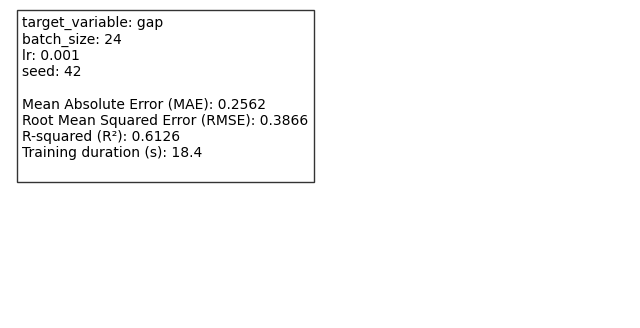

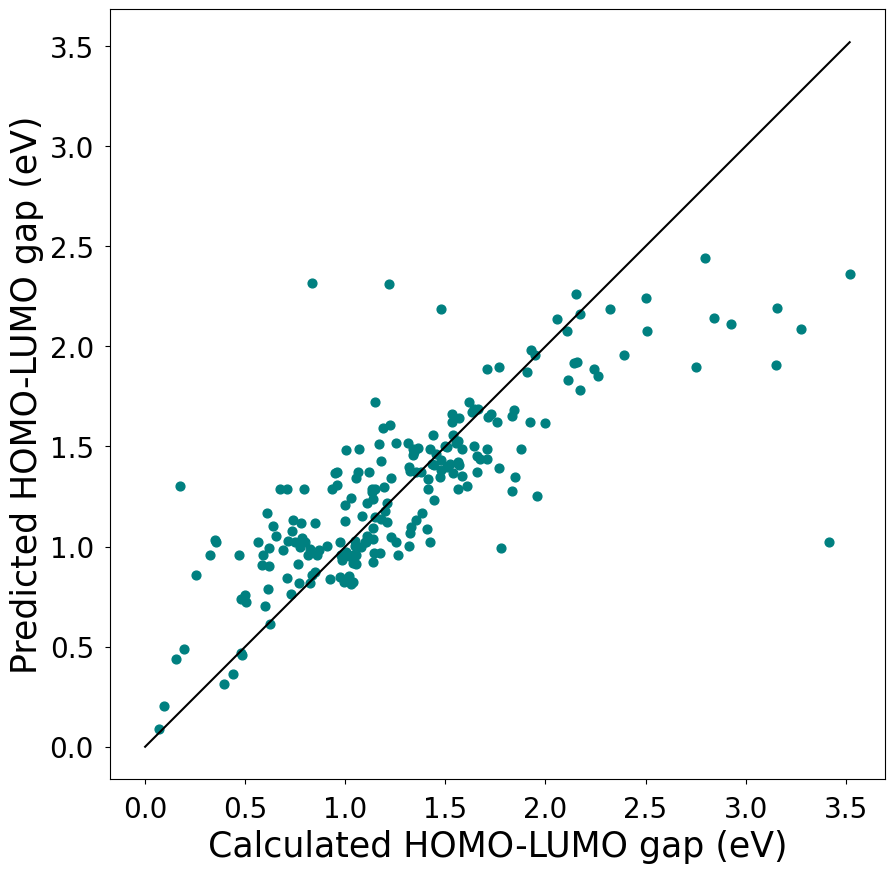

In [ ]:
os.chdir("/content/drive/MyDrive/AuNC database/fig4_plots")

target_variable = "gap"
batch_size = 24
learning_rate=0.001
patience = 40
Filename = "CNN" + "_" + target_variable
seed = 42
model_save_name = "best_cnn_gap.h5"
if target_variable == "u298": tick_sep=150
elif target_variable == "gap": tick_sep=0.5
else: tick_sep=50

parameters = {'target_variable': target_variable, 'batch_size': batch_size, "lr": learning_rate, "seed": seed}

predicted_values, true_values, duration = run_cnn_leave_one_out(Dataset=DatasetAuNC,
                                                                sample_size=len(DatasetAuNC),
                                                                target_variable=target_variable,
                                                                batch_size=batch_size, learning_rate=learning_rate, patience=patience,
                                                                model_save_name=model_save_name,
                                                                random_state=seed,
                                                                use_simplex=True, use_charge=True,
                                                                )
analyze_regression_performance(true_values, predicted_values, parameters, duration, save_image=False, image_name=Filename+"_data.png")
plot_ML_results(true_values, predicted_values, x_tick_sep=tick_sep, y_tick_sep=tick_sep, save_image=False, image_name=Filename+".pdf")